In [8]:
%load_ext autoreload
%autoreload 2
from types import SimpleNamespace
import json
import os
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from models.efficient_unet import AbstractUNet
from dataset import CatDataset
from inpaint_tools import read_file_list
from skimage import io
import numpy as np
from skimage.restoration import inpaint_biharmonic
import torchvision.transforms as transforms
from pathlib import Path
from tqdm import tqdm
import json
import pathlib
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load settings

In [18]:
# Read JSON data from a file
with open('my_inpaint_config.json', 'r') as json_file:
    json_data = json_file.read()

# Parse JSON data into a dictionary
settings = json.loads(json_data)

# ADD DATASET
settings["data_set"] =  "test_200"

# Extract information
output_data_dir = settings["dirs"]["output_data_dir"]
data_set = settings["data_set"]
team_name = settings["team_data"]["name"]
method_name = settings["training_parms"]["method"]
inpainted_result_dir = os.path.join(output_data_dir, f"inpainted_{method_name}_{data_set}")
pathlib.Path(inpainted_result_dir).mkdir(parents=True, exist_ok=True)

# Load data

In [19]:
dataset = CatDataset(settings, test = True)
print([d.shape for d in dataset[0]])
file_ids = dataset.file_ids

[torch.Size([4, 360, 360]), torch.Size([1, 360, 360])]


In [ ]:
def show_img(img, mask, generated_img):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].imshow(np.moveaxis(img, 0, -1))  # Transpose the array to (360, 360, 3)
    ax[0].axis('off') 
    ax[1].imshow(mask)  # Transpose the array to (360, 360, 3)
    ax[1].axis('off')
    ax[2].imshow(generated_img)  # Transpose the array to (360, 360, 3)
    ax[2].axis('off')
    # Turn off axes
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

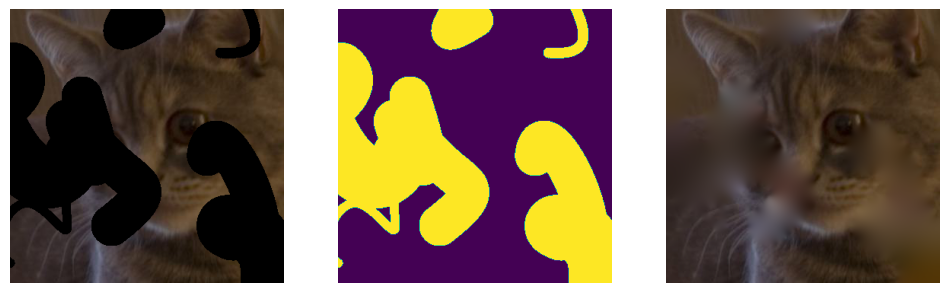

100%|██████████| 200/200 [09:56<00:00,  2.98s/it]


In [ ]:
with tqdm(total=len(file_ids)) as pbar:
    for file_id, data in zip(file_ids, dataset):
        img_w_mask, _, = data
        img, mask  = img_w_mask[:3].numpy(), img_w_mask[3].numpy()
        generated_img = inpaint_biharmonic(img, mask, channel_axis=0)
        generated_img = (generated_img*255).astype(np.uint8)
        generated_img = np.moveaxis(generated_img, 0, -1)
        generated_img_name = os.path.join(inpainted_result_dir, f"{file_id}_generated.png")
        io.imsave(generated_img_name, generated_img)
        pbar.update(1) 

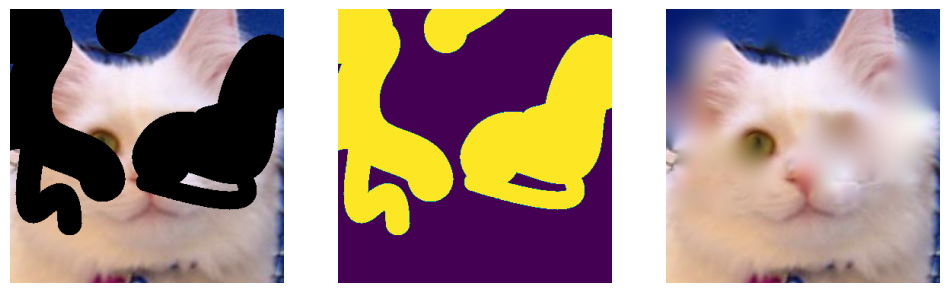

In [24]:
show_img(img, mask, generated_img)